In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
device = torch.device('cuda') if (torch.cuda.is_available()) else torch.device('cpu')
device

device(type='cpu')

In [ ]:
complete = pd.read_csv('EOF.csv')
# data is cut off because collab didnt finish loading the entire csv
# which is why we have < 1.2 million rows here
complete

,folderidx,float,profileidx,year,month,day,lat,lon,nlat,nlon,...,ts4,ts5,ts6,ts7,ts8,ssh_slope,ssh_dir,bath_slope,bath_dir,roughness
0,0.0,1901932.0,0.0,2021.0,5.0,20.0,-39.790000,30.06350,-36.81700,30.94190,...,-1.469766,-0.750992,-0.662656,-0.047516,-0.002373,0.0,0.0,0.0,0.0,0.0
1,0.0,1901932.0,1.0,2021.0,5.0,30.0,-36.817000,30.94190,-38.45100,32.75650,...,-4.411510,0.422385,-0.068476,-0.906169,-0.072356,0.0,0.0,0.0,0.0,0.0
2,0.0,1901932.0,2.0,2021.0,6.0,9.0,-38.451000,32.75650,-40.03020,35.96520,...,-0.668177,-0.787948,-0.472165,0.048625,0.050058,0.0,0.0,0.0,0.0,0.0
3,0.0,1901932.0,3.0,2021.0,6.0,19.0,-40.030200,35.96520,-39.29690,38.69280,...,-1.104086,-0.824606,-0.262984,0.291729,-0.280132,0.0,0.0,0.0,0.0,0.0
4,0.0,1901932.0,4.0,2021.0,6.0,29.0,-39.296900,38.69280,-38.02270,40.90310,...,-0.764814,-0.671834,-0.252487,0.113580,0.043449,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829270,6.0,5902485.0,117.0,2019.0,12.0,4.0,-42.983190,101.21977,-42.49505,100.79281,...,-4.764732,0.034321,-0.253332,-0.321717,0.227987,0.0,0.0,0.0,0.0,0.0
829271,6.0,5902485.0,118.0,2019.0,12.0,14.0,-42.495050,100.79281,-42.27993,100.41431,...,-4.577640,-0.112698,-0.380702,-0.271047,0.224090,0.0,0.0,0.0,0.0,0.0
829272,6.0,5902485.0,119.0,2019.0,12.0,24.0,-42.279930,100.41431,-42.23436,100.40277,...,-4.325614,-0.198941,-0.390504,-0.194860,0.083056,0.0,0.0,0.0,0.0,0.0
829273,6.0,5902485.0,120.0,2020.0,1.0,3.0,-42.234360,100.40277,-42.11787,100.92618,...,-4.443184,-0.105267,-0.220553,-0.300120,0.310168,0.0,0.0,0.0,0.0,0.0


In [ ]:
data = complete.assign(dy=complete.get('nlat')-complete.get('lat'));
data = data.assign(dx=data.get('nlon')-data.get('lon'));
data = data.assign(magnitude=np.sqrt(data.get('dy')**2 + data.get('dx')**2))
data = data.assign(angle=np.arctan2(data.get('dy'), data.get('dx')))
data = data[['ts1', 'ts2', 'ts3', 'ts4', 'ts5', 'ts6', 'ts7', 'ts8', 'angle', 'magnitude']].dropna()
data

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,angle,magnitude
0,-8.429544,-2.753714,-2.788564,-1.469766,-0.750992,-0.662656,-0.047516,-0.002373,1.283511,3.100051
1,-16.224981,-2.328750,-2.156176,-4.411510,0.422385,-0.068476,-0.906169,-0.072356,-0.733077,2.441870
2,-4.645711,-3.005418,-1.453715,-0.668177,-0.787948,-0.472165,0.048625,0.050058,-0.457358,3.576259
3,-7.028408,-3.373396,-2.194893,-1.104086,-0.824606,-0.262984,0.291729,-0.280132,0.262634,2.824452
4,-3.312371,-3.200434,-1.266698,-0.764814,-0.671834,-0.252487,0.113580,0.043449,0.522948,2.551276
...,...,...,...,...,...,...,...,...,...,...
829269,-5.992957,-3.378035,0.049777,-4.674880,-0.021210,-0.572063,-0.306225,-0.018893,0.778633,0.388819
829270,-6.035303,-3.410081,0.329362,-4.764732,0.034321,-0.253332,-0.321717,0.227987,2.289438,0.648518
829271,-5.146897,-3.436023,0.396059,-4.577640,-0.112698,-0.380702,-0.271047,0.224090,2.624771,0.435361
829272,-4.941638,-3.488744,0.085608,-4.325614,-0.198941,-0.390504,-0.194860,0.083056,1.818819,0.047008


In [ ]:
Y = torch.tensor(data[['angle', 'magnitude']].to_numpy()).float().to(device)
X = torch.tensor(data.drop(columns=['angle', 'magnitude']).to_numpy()).float().to(device)

# TODO: instead of doing a naive shuffle, keep profiles specific to floats (or regions) grouped together
X, Y = shuffle(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

training loss: 1.5452147
test loss: 2.3421018


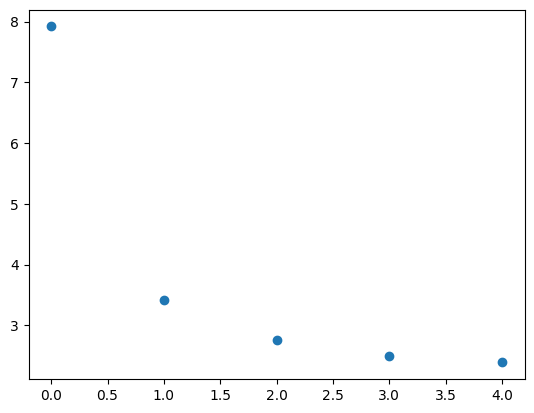

In [ ]:
model = nn.Sequential(
    nn.Linear(8, 2)
).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()


losses = []
for epoch in range(5):
  optimizer.zero_grad()

  guess = model(X_train)
  loss = criterion(guess, Y_train)
  loss.backward()
  optimizer.step()

  losses.append(loss.cpu().detach().numpy())

print("training loss:", np.sqrt(losses[-1]))
print("test loss:", criterion(model(X_test), Y_test).cpu().detach().numpy())
plt.scatter(np.arange(5), losses)

In [35]:
# picking a contiguous sequence
just_one = complete[complete.get('float') == 5903581.0].head(6)
small_test = torch.tensor(just_one[['ts1', 'ts2', 'ts3', 'ts4', 'ts5', 'ts6', 'ts7', 'ts8']].to_numpy()).float().to(device)
pred = model(small_test).detach().numpy()
dx = pred[:, 0] * np.cos(pred[:,1])
dy = pred[:, 0] * np.sin(pred[:,1])
just_one = just_one.assign(pnlat = dy+just_one.get('lat'))
just_one = just_one.assign(pnlon = dx+just_one.get('lon')).reset_index()
just_one

,index,folderidx,float,profileidx,year,month,day,lat,lon,nlat,...,ts6,ts7,ts8,ssh_slope,ssh_dir,bath_slope,bath_dir,roughness,pnlat,pnlon
0,629023,6.0,5903581.0,0.0,2013.0,11.0,11.0,-32.950,-45.157,-32.045,...,-0.580614,0.518850,-1.293023,0.0,0.0,0.0,0.0,0.0,-32.703133,-46.494368
1,629024,6.0,5903581.0,1.0,2013.0,11.0,21.0,-32.045,-45.792,-30.739,...,-0.883117,-0.075921,-1.072912,0.0,0.0,0.0,0.0,0.0,-32.386511,-47.278041
2,629025,6.0,5903581.0,2.0,2013.0,12.0,1.0,-30.739,-46.463,-30.839,...,-0.957763,-0.159207,-0.745878,0.0,0.0,0.0,0.0,0.0,-30.907005,-47.996957
3,629026,6.0,5903581.0,3.0,2013.0,12.0,11.0,-30.839,-47.600,-30.793,...,-1.483801,-0.563997,-0.870777,0.0,0.0,0.0,0.0,0.0,-31.536045,-49.349051
4,629027,6.0,5903581.0,5.0,2013.0,12.0,31.0,-30.914,-47.448,-31.095,...,-0.532555,-0.020968,-0.834839,0.0,0.0,0.0,0.0,0.0,-30.771933,-48.613484
5,629028,6.0,5903581.0,6.0,2014.0,1.0,11.0,-31.095,-48.860,-31.092,...,-0.212721,-0.523518,-0.296322,0.0,0.0,0.0,0.0,0.0,-31.049513,-49.807314


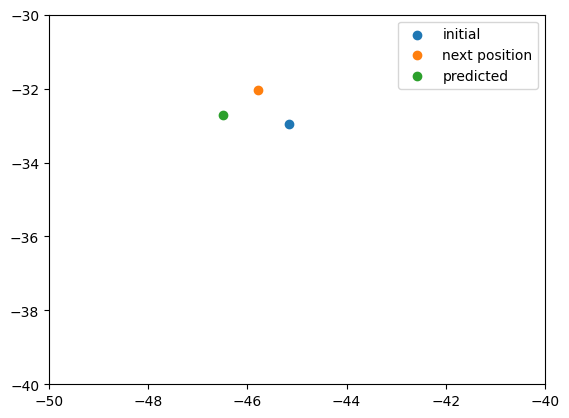

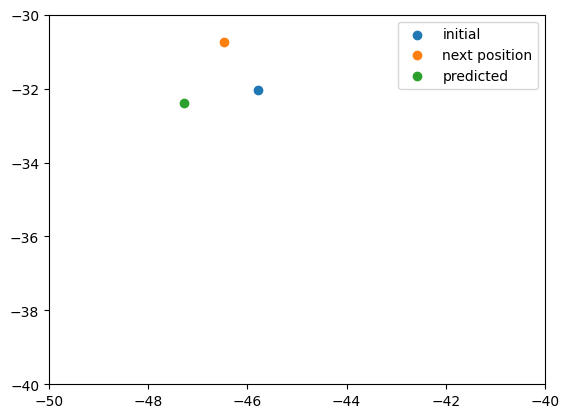

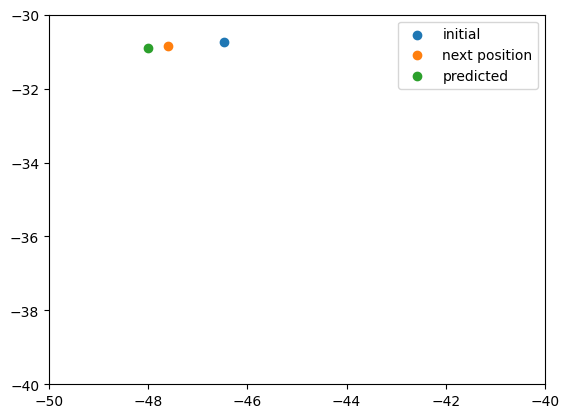

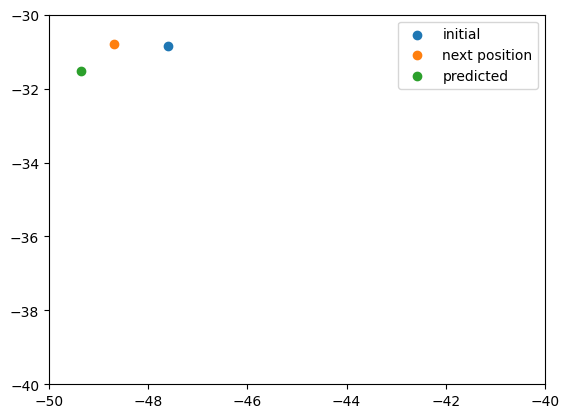

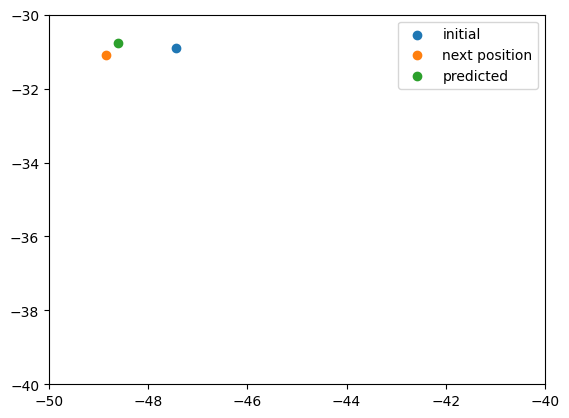

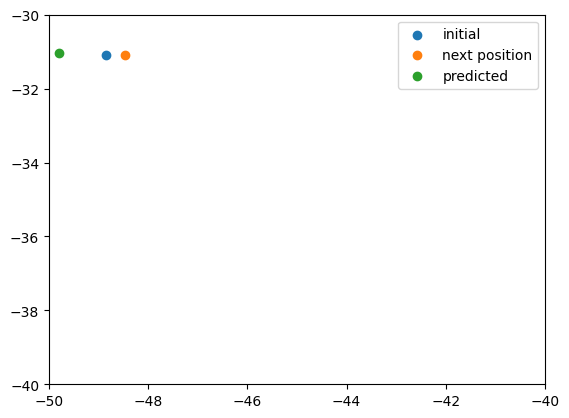

In [36]:
for i in range(just_one.shape[0]):
  y_plot = [just_one.get('lat')[i], just_one.get('nlat')[i], just_one.get('pnlat')[i]]
  x_plot = [just_one.get('lon')[i], just_one.get('nlon')[i], just_one.get('pnlon')[i]]
  for j in range(3):
    plt.scatter(x_plot[j], y_plot[j])
  plt.legend(['initial', 'next position', 'predicted'])
  plt.xlim((-50, -40))
  plt.ylim((-40, -30))
  plt.show()